# Traffic Flow Regression - V2
## - <i>Feature Engineering and Combining Datasources </i>
 - this notebook builds upon traffic_flow_regression_V1 through feature engineering and integrating relevant datasets from multiple sources
 - see EDA.ipynb for a deeper understanding of the data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import sys, os 
import requests

sys.path.append(os.path.join(os.getcwd(), 'utils'))


## Prepare Dataset
Let's challenge ourselves more in V2 and keep the traffic flow in 30 minute intervals rather than hours. This will require a more fine-tuned model. We could keep 15 minute intervals but 30 minutes intuitively seems more sensible and reduces the amount of non interesting intervals (0 flow)

In [2]:

# Load the dataset
df = pd.read_csv('ml_datasets/traffic_flow_regression.csv')

# Convert 'start_time' and 'date' to datetime
df['start_time'] = pd.to_datetime(df['start_time'])
df['date'] = pd.to_datetime(df['date'])

# Round the start_time to the nearest half-hour
df['start_time'] = df['start_time'].dt.round('30min')

# Extract half-hour intervals (0 for the hour, 30 for half past)
df['time_(half_hour)'] = df['start_time'].dt.strftime('%H:%M')

# Group by the new half-hour intervals along with other specified columns
df = df.groupby(['time_(half_hour)', 'start_time', 'site', 'day', 'date', 'X', 'Y']).agg({'flow': 'sum'}).reset_index()

# Display the first few rows
df


/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_16051/558945045.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_time'] = pd.to_datetime(df['start_time'])


,time_(half_hour),start_time,site,day,date,X,Y,flow
0,00:00,2024-10-23 00:00:00,N01111A,FR,2022-01-04,-6.356151,53.293594,79
1,00:00,2024-10-23 00:00:00,N01111A,FR,2022-01-14,-6.356151,53.293594,58
2,00:00,2024-10-23 00:00:00,N01111A,FR,2022-01-21,-6.356151,53.293594,43
3,00:00,2024-10-23 00:00:00,N01111A,FR,2022-01-28,-6.356151,53.293594,58
4,00:00,2024-10-23 00:00:00,N01111A,FR,2022-02-18,-6.356151,53.293594,69
...,...,...,...,...,...,...,...,...
35515,23:30,2024-10-23 23:30:00,N03121A,WE,2022-05-25,-6.424314,53.357202,67
35516,23:30,2024-10-23 23:30:00,N03121A,WE,2022-06-04,-6.424314,53.357202,104
35517,23:30,2024-10-23 23:30:00,N03121A,WE,2022-06-15,-6.424314,53.357202,68
35518,23:30,2024-10-23 23:30:00,N03121A,WE,2022-06-22,-6.424314,53.357202,74


# Feature Engineering
- Feature engineering is the process of selecting, manipulating and transforming raw data into features that can be used in supervised learning
- A crucial aspect of a data scientists job is to create features that are predictive from the raw data
- This is one reason why domain knowledge can be particularly important for a data scientist in their job. But also creativity and logical thinking are a part of it too

## What causes traffic?
- Luckily I don't particularly need much domain knowledge to get started. I live in Dublin and drive so that qualifies me somewhat!
- We already use the day and the time of day as features which are probably the most predictive features I would think to predict traffic flow in general, other than specific instances like car accidents and road works
- These features were pretty much handed to us. But is there anything else there that could be predictive
### 1. The month!
- I've always noticed traffic to be much better when schools are off so maybe including information on the month could be useful for us
- We record the traffic on a given date but over a 6 month time window obviously each date is unique making it an unuseful feature
- By instead extracting the month we can make what was an unuseful feature (the date) into something that might be useful


Create a month column from the date column

In [3]:
df['month'] = df['date'].dt.month
df.head()

,time_(half_hour),start_time,site,day,date,X,Y,flow,month
0,00:00,2024-10-23,N01111A,FR,2022-01-04,-6.356151,53.293594,79,1
1,00:00,2024-10-23,N01111A,FR,2022-01-14,-6.356151,53.293594,58,1
2,00:00,2024-10-23,N01111A,FR,2022-01-21,-6.356151,53.293594,43,1
3,00:00,2024-10-23,N01111A,FR,2022-01-28,-6.356151,53.293594,58,1
4,00:00,2024-10-23,N01111A,FR,2022-02-18,-6.356151,53.293594,69,2


In a similar manner we can create the hour as a feature as was done in V1 but abstracting a bit more for this version where we can predict flow in shorter intervals

In [4]:
df['time_(hour)'] = df['start_time'].dt.hour


## What causes Traffic (cont)
- That was a pretty easy addition of a feature. Whether it ends up being super predictive or not isn't what's important right now, but more the principle of how features can be created that may be useful from what is handed to us
- One thing I noticed from the V1 notebook is the isolation of each site. I think it makes sense to have separate models for each site but we are then isolating a dataset of 40,000 samples into ~7000 per site.
### 2. Traffic Flow at other junctions 
- Well as we saw in our EDA some of the sites are quite close together. So if one site has a lot of traffic flow surely that would predict that the other sites close to it would also have traffic flow as cars may be driving through different sites
- To model this, let's create a feature for each sample that is the amount of traffic flow in all the sites in the <b> previous interval </b> to that sample.
 #### ** NB: Data Leakage **
- Let's make up a use case for this model as that we are building a real time traffic control system for these sites
- Here the model has already been trained and is being fed data live and every half an hour it predicts what the traffic flow is going to be for the next half an hour. Since one of our features is going to be traffic flow at other junctions, this will be fed too.
- Obviously in this scenario **we do not have the traffic flow data for the other sites for that interval as it hasn't happened yet**.
- Therefore the data we would have available to us that is useful is the traffic flow data from the previous interval
- This may seem obvious but when building and training a model on historical data, it can become easy to just see the dataset as a bunch of numbers and forget where they are coming from in the real world
- This is something that separates building a model for fun and learning about machine learning to actually putting a model out there in production that has use in the real world.

Create a datetime column

In [5]:
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time_(half_hour)'])


Function to get the flow at the previous interval in time

In [6]:

# Get all unique sites
unique_sites = df['site'].unique()

# Create a function to calculate the previous flow for all other sites
def calculate_previous_flow_for_sites(row, site):
    # Get the time of the current row
    current_time = row['datetime']
    
    # Find the previous interval
    previous_time = current_time - pd.Timedelta(minutes=30)
    
    # Filter the flow for the specific site at the previous time
    previous_flow = df[(df['datetime'] == previous_time) & (df['site'] == site)]['flow']
    
    # Return the flow value if it exists, else 0
    return previous_flow.iloc[0] if not previous_flow.empty else 0

# For each unique site, create a column with the flow of that site in the previous interval
# for site in unique_sites:
#     df[f'previous_flow_{site}'] = df.apply(calculate_previous_flow_for_sites, axis=1, site=site)

df = pd.read_csv('ml_datasets/traffic_flow_regression_mod.csv', index_col=None)

# Display the updated DataFrame
df.head()

,time_(half_hour),start_time,site,day,date,X,Y,flow,month,time_(hour),datetime,previous_flow_N01111A,previous_flow_N01131A,previous_flow_N01151A,previous_flow_N02111A,previous_flow_N02131A,previous_flow_N03121A,overall_previous_flow
0,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-04,-6.356151,53.293594,79,1,0,2022-01-04 00:00:00,25,0,26,53,29,68,201
1,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-14,-6.356151,53.293594,58,1,0,2022-01-14 00:00:00,35,0,25,68,39,17,184
2,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-21,-6.356151,53.293594,43,1,0,2022-01-21 00:00:00,32,0,30,62,35,58,217
3,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-28,-6.356151,53.293594,58,1,0,2022-01-28 00:00:00,45,0,32,91,45,50,263
4,00:00,2024-10-12 00:00:00,N01111A,FR,2022-02-18,-6.356151,53.293594,69,2,0,2022-02-18 00:00:00,58,0,37,63,52,53,263


Create a column that is the overall previous flow across all sites

In [7]:
df['overall_previous_flow'] = df[[f'previous_flow_{site}' for site in unique_sites]].sum(axis=1)
df.head()

,time_(half_hour),start_time,site,day,date,X,Y,flow,month,time_(hour),datetime,previous_flow_N01111A,previous_flow_N01131A,previous_flow_N01151A,previous_flow_N02111A,previous_flow_N02131A,previous_flow_N03121A,overall_previous_flow
0,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-04,-6.356151,53.293594,79,1,0,2022-01-04 00:00:00,25,0,26,53,29,68,201
1,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-14,-6.356151,53.293594,58,1,0,2022-01-14 00:00:00,35,0,25,68,39,17,184
2,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-21,-6.356151,53.293594,43,1,0,2022-01-21 00:00:00,32,0,30,62,35,58,217
3,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-28,-6.356151,53.293594,58,1,0,2022-01-28 00:00:00,45,0,32,91,45,50,263
4,00:00,2024-10-12 00:00:00,N01111A,FR,2022-02-18,-6.356151,53.293594,69,2,0,2022-02-18 00:00:00,58,0,37,63,52,53,263


## Let's see model performance with these additional features

Mean Absolute Error (MAE) Test: 73.22184684684684
Mean Absolute Error (MAE) Train: 0.597972972972973
Root Mean Squared Error (RMSE) Test: 134.81967122790354
Root Mean Squared Error (RMSE) Train: 4.814034163248628
R-squared (R²) Test: 0.9194267391035644
R-squared (R²) Train: 0.9998976646366584
Mean Absolute Percentage Error (MAPE) Test: 16.0%
Mean Absolute Percentage Error (MAPE) Train: 0.1%


/Users/eoinmolloy/Documents/github/Traffic-Flow-SDCC/utils/DecisionTree_site.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[importance for name, importance in self.sorted_feature_importances],


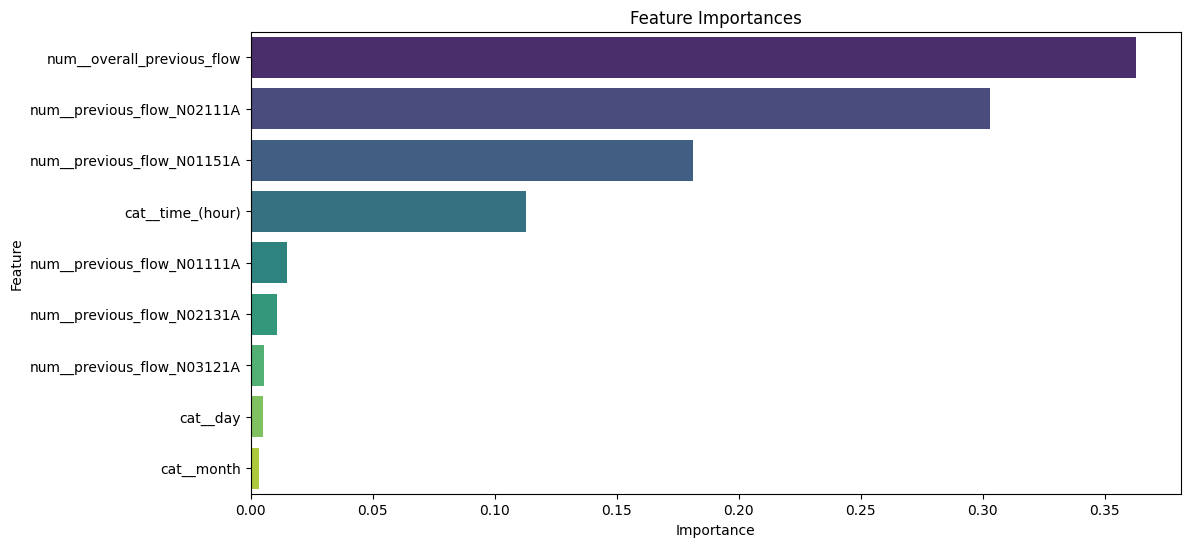

In [8]:
cat_features = ['day', 'time_(hour)', 'month']
num_features = ['previous_flow_N01111A','previous_flow_N01151A','previous_flow_N02111A','previous_flow_N02131A','previous_flow_N03121A','overall_previous_flow']
# Now, import the module
import DecisionTree_site 
dt = DecisionTree_site.DecisionTree('N01111A', cat_features, num_features, 'flow', df)

dt.transform_split_train_score_eval()



Observations
- The MAE is lower than what was seen in V1 showing that adding features has increased the performance of the model

### 2. Traffic Flow at other junctions - Distance between sites
- We saw that adding the flow at other sites has increased the accuracy of the model.
- One thing I'd imagine is that the flow across sites that are close together would influence each other the most.
- We have the longitude and latitude of each site location so lets use the mapbox API to find the distance each site is relative to each other
- See https://docs.mapbox.com/api/overview/ for more details on the mapbox API

#### Mapbox API Prerequisities

- Access token

In [9]:
path_to_file = '../../env_variables.txt'
with open(path_to_file) as file:
    for line in file:
        name, value = line.strip().split('=')
        os.environ[name] = value
ACCESS_TOKEN = os.getenv('MAPBOX_API_KEY')

- Function to create correct url for coordinates

In [10]:
def define_url(coordinates):
    return f"https://api.mapbox.com/directions/v5/mapbox/driving-traffic/{coordinates}?geometries=geojson&access_token={ACCESS_TOKEN}"

- Function to get travel distance & length between site 1 and site 2

In [11]:
def call_mapbox_api(site1, site2):
    if site1==site2:
        duration = 0
        distance = 0
        return duration, distance
    # Drop duplicates based on the 'X' column and keep only the first two unique entries
    df_unique = df.drop_duplicates(subset=['X'])
    
    # Filter for specific columns and rows based on site1 and site2
    result = df_unique[df_unique['site'].isin([site1, site2])]

    coordinates = ';'.join(result.apply(lambda row: f"{row['X']},{row['Y']}", axis=1))

    url = define_url(coordinates)

    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        duration = data['routes'][0]['duration_typical']
        distance = data['routes'][0]['distance'] # Do something with the response data
    else:
        print(f"Error: {response.status_code}, {response.text}")

    return duration, distance


Create a dictionary to store the travel routes between each site

In [12]:
site_routes = {
    site: {
        other_site: {'duration': call_mapbox_api(site, other_site)[0], 
                     'distance': call_mapbox_api(site, other_site)[1]}
        for other_site in unique_sites
    }
    for site in unique_sites
}


Add these distances as features in the dataframe

In [13]:
def get_distance(current_site, other_site, site_routes):
    if current_site in site_routes and other_site in site_routes[current_site]:
        return site_routes[current_site][other_site]['distance']
def get_duration(current_site, other_site, site_routes):
    if current_site in site_routes and other_site in site_routes[current_site]:
        return site_routes[current_site][other_site]['duration']

# Loop through each site and add columns only if distance exists
for site in unique_sites:
    # Check if there's at least one non-None distance for the current site
    distance_col_name = f'distance_{site}'
    duration_col_name = f'duration_{site}'
    
    df[distance_col_name] = df['site'].apply(lambda x: get_distance(x, site, site_routes))
    df[duration_col_name] = df['site'].apply(lambda x: get_duration(x, site, site_routes))


## Let's see model performance with these additional features

In [27]:
cat_features = ['day', 'time_(hour)', 'month']
num_features = ['previous_flow_N01111A','previous_flow_N01151A','previous_flow_N02111A','previous_flow_N02131A','previous_flow_N03121A','overall_previous_flow',
                'distance_N01111A',
       'duration_N01111A',
       'distance_N01151A', 'duration_N01151A', 'distance_N02111A',
       'duration_N02111A', 'distance_N02131A', 'duration_N02131A',
       'distance_N03121A', 'duration_N03121A']
# Now, import the module
import DecisionTree_site 
dt = DecisionTree_site.DecisionTree('N03121A', cat_features, num_features, 'flow', df)



Mean Absolute Error (MAE) Test: 79.84994369369369
Mean Absolute Error (MAE) Train: 0.6308183183183184
Root Mean Squared Error (RMSE) Test: 140.1919086667652
Root Mean Squared Error (RMSE) Train: 5.048795310178863
R-squared (R²) Test: 0.9034573079989613
R-squared (R²) Train: 0.999881645893707
Mean Absolute Percentage Error (MAPE) Test: 17.1%
Mean Absolute Percentage Error (MAPE) Train: 0.1%


/Users/eoinmolloy/Documents/github/Traffic-Flow-SDCC/utils/DecisionTree_site.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[importance for name, importance in self.sorted_feature_importances],


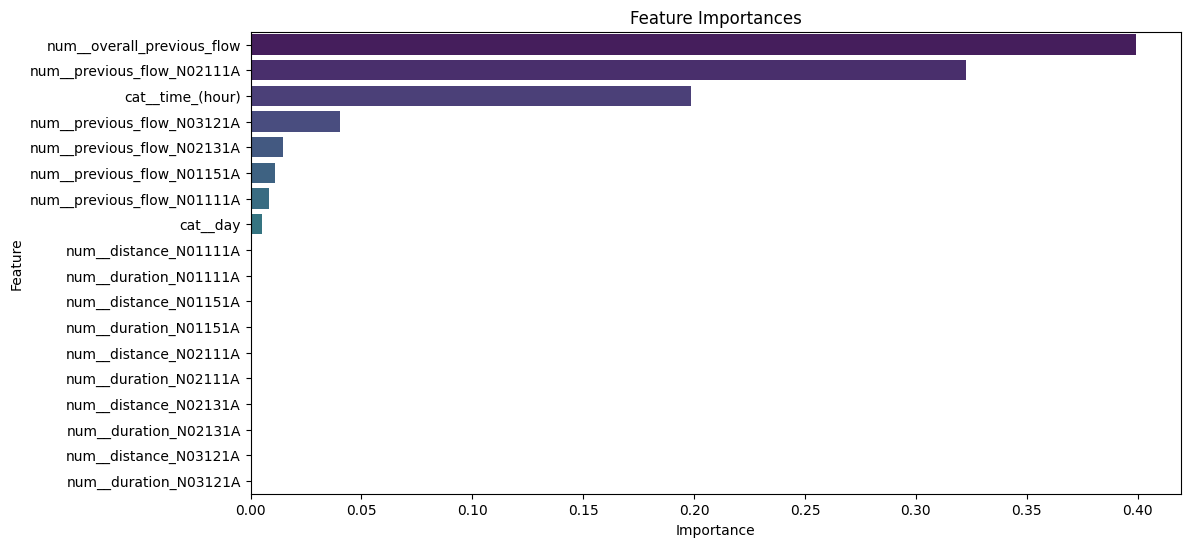

In [15]:
dt.transform_split_train_score_eval()

Observations
- The model performance is basically the same. We might have expected this as the effect proximity of other junctions flow is essentially being learned anyway by the model

### 3. Weather Conditions
- another factor that comes to mind that could influence traffic would be the weather! Whether that's people driving slower on icy roads or a big rush to drive to the sea on a sunny day, the weather 
definitely has influenced traffic patterns in my own personal experience
- I have downloaded a dataset of weather conditions here just to mix it up from using an API like with mapbox. However there are free weather APIs that could be used as well.

In [16]:
# Read in from CSV file
weather_data = pd.read_csv('data/historical_weather_phoenix_park.csv')
# Convert date column to date time
weather_data['date'] = pd.to_datetime(weather_data['date'], format='mixed')
df['date'] = pd.to_datetime(df['date'])
# Filter data to only dates we are working with
weather_data = weather_data[(weather_data['date'] >= df['date'].min()) & (weather_data['date'] <= df['date'].max()+ pd.Timedelta(days=1))]
weather_data

/var/folders/5g/y4dx7m714l7ft2p__s3ybpn80000gn/T/ipykernel_16051/4138777319.py:2: DtypeWarning: Columns (2,4,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data = pd.read_csv('data/historical_weather_phoenix_park.csv')


,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
161111,2022-01-01 00:00:00,0,0.0,0,13.1,0,11.4,9.8,12.1,80,1007.3
161112,2022-01-01 01:00:00,0,0.0,0,13.9,0,11.2,8.5,11.1,70,1005.8
161113,2022-01-01 02:00:00,0,0.0,0,14.0,0,11.0,8.1,10.8,67,1005.0
161114,2022-01-01 03:00:00,0,0.0,0,14.6,0,11.4,8.4,11.0,66,1003.9
161115,2022-01-01 04:00:00,0,0.0,0,14.9,0,12.1,9.5,11.9,70,1002.7
...,...,...,...,...,...,...,...,...,...,...,...
165451,2022-06-30 20:00:00,0,0.0,0,15.0,0,12.4,10.1,12.3,72,1012.3
165452,2022-06-30 21:00:00,0,0.0,0,14.4,0,12.1,10.0,12.3,75,1012.6
165453,2022-06-30 22:00:00,0,0.0,0,13.7,0,11.9,10.3,12.5,79,1013.1
165454,2022-06-30 23:00:00,0,0.0,0,13.2,0,11.7,10.3,12.5,82,1013.2


Column name meanings


| **Date and Time (UTC)** | **Precipitation Amount (mm)** | **Air Temperature (°C)** | **Wet Bulb Temperature (°C)** | **Dew Point Temperature (°C)** | **Vapour Pressure (hPa)** | **Relative Humidity (%)** | **Mean Sea Level Pressure (hPa)** | **Indicator** |
|------------------------|-------------------------------|--------------------------|-------------------------------|--------------------------------|--------------------------|---------------------------|----------------------------------|---------------|
| date                   | rain                          | temp                     | wetb                          | dewpt                         | vappr                    | rhum                      | msl                              | ind           |


**Note:** Please see the appendix for an EDA of this weather data

#### Join the weather data onto the traffic dataset

In [17]:
# Ensure both columns are datetime
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Get rounded datetime to nearest hour in traffic dataset
df['datetime'] = pd.to_datetime(df['datetime'])
df['rounded_datetime'] = df['datetime'].dt.round('h')
df['rounded_datetime'] = pd.to_datetime(df['rounded_datetime'])

# Remove date column in weather data before join
df2_filtered = weather_data.drop(columns=['date'])
df = df.merge(df2_filtered, left_on='rounded_datetime', right_on=weather_data['date'], how='left')
df.head()

,time_(half_hour),start_time,site,day,date,X,Y,flow,month,time_(hour),...,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
0,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-04,-6.356151,53.293594,79,1,0,...,0,0.0,0,3.6,0,2.2,-0.3,6.0,75,1003.5
1,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-14,-6.356151,53.293594,58,1,0,...,0,0.0,0,4.1,0,3.5,2.6,7.4,90,1039.5
2,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-21,-6.356151,53.293594,43,1,0,...,0,0.0,0,4.9,0,3.9,2.5,7.3,84,1042.1
3,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-28,-6.356151,53.293594,58,1,0,...,0,0.0,0,2.9,0,2.6,2.0,7.1,93,1035.3
4,00:00,2024-10-12 00:00:00,N01111A,FR,2022-02-18,-6.356151,53.293594,69,2,0,...,0,1.0,0,4.0,0,3.5,2.7,7.4,91,995.2


Ensure no null entries

In [18]:
null_rows = df[df.isnull().any(axis=1)]
# Display the first few rows with null values
null_rows.head()

,time_(half_hour),start_time,site,day,date,X,Y,flow,month,time_(hour),...,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
145,00:00,2024-10-12 00:00:00,N01131A,FR,2022-02-18,-6.352204,53.301229,0,2,0,...,0,1.0,0,4.0,0,3.5,2.7,7.4,91,995.2
146,00:00,2024-10-12 00:00:00,N01131A,FR,2022-02-25,-6.352204,53.301229,0,2,0,...,0,0.0,0,3.2,0,2.3,0.7,6.4,83,1017.9
147,00:00,2024-10-12 00:00:00,N01131A,FR,2022-03-06,-6.352204,53.301229,0,3,0,...,0,0.0,0,-1.6,0,-1.9,-2.5,5.1,93,1034.0
148,00:00,2024-10-12 00:00:00,N01131A,FR,2022-03-18,-6.352204,53.301229,0,3,0,...,0,0.0,0,1.9,0,1.6,1.0,6.6,94,1037.2
149,00:00,2024-10-12 00:00:00,N01131A,FR,2022-03-25,-6.352204,53.301229,0,3,0,...,0,0.0,0,7.1,0,6.3,5.4,9.0,89,1031.0


In [19]:
df

,time_(half_hour),start_time,site,day,date,X,Y,flow,month,time_(hour),...,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
0,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-04,-6.356151,53.293594,79,1,0,...,0,0.0,0,3.6,0,2.2,-0.3,6.0,75,1003.5
1,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-14,-6.356151,53.293594,58,1,0,...,0,0.0,0,4.1,0,3.5,2.6,7.4,90,1039.5
2,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-21,-6.356151,53.293594,43,1,0,...,0,0.0,0,4.9,0,3.9,2.5,7.3,84,1042.1
3,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-28,-6.356151,53.293594,58,1,0,...,0,0.0,0,2.9,0,2.6,2.0,7.1,93,1035.3
4,00:00,2024-10-12 00:00:00,N01111A,FR,2022-02-18,-6.356151,53.293594,69,2,0,...,0,1.0,0,4.0,0,3.5,2.7,7.4,91,995.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41394,23:30,2024-10-12 23:30:00,N03121A,WE,2022-05-25,-6.424314,53.357202,67,5,23,...,0,0.0,0,10.5,0,9.2,7.9,10.7,84,1016.5
41395,23:30,2024-10-12 23:30:00,N03121A,WE,2022-06-04,-6.424314,53.357202,104,6,23,...,0,0.0,0,12.4,0,10.7,9.0,11.5,80,1019.8
41396,23:30,2024-10-12 23:30:00,N03121A,WE,2022-06-15,-6.424314,53.357202,68,6,23,...,0,0.0,0,11.3,0,10.9,10.5,12.7,94,1020.9
41397,23:30,2024-10-12 23:30:00,N03121A,WE,2022-06-22,-6.424314,53.357202,74,6,23,...,0,0.0,0,16.0,0,14.9,14.1,16.0,88,1012.7


In [28]:
df

,time_(half_hour),start_time,site,day,date,X,Y,flow,month,time_(hour),...,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
0,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-04,-6.356151,53.293594,79,1,0,...,0,0.0,0,3.6,0,2.2,-0.3,6.0,75,1003.5
1,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-14,-6.356151,53.293594,58,1,0,...,0,0.0,0,4.1,0,3.5,2.6,7.4,90,1039.5
2,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-21,-6.356151,53.293594,43,1,0,...,0,0.0,0,4.9,0,3.9,2.5,7.3,84,1042.1
3,00:00,2024-10-12 00:00:00,N01111A,FR,2022-01-28,-6.356151,53.293594,58,1,0,...,0,0.0,0,2.9,0,2.6,2.0,7.1,93,1035.3
4,00:00,2024-10-12 00:00:00,N01111A,FR,2022-02-18,-6.356151,53.293594,69,2,0,...,0,1.0,0,4.0,0,3.5,2.7,7.4,91,995.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41394,23:30,2024-10-12 23:30:00,N03121A,WE,2022-05-25,-6.424314,53.357202,67,5,23,...,0,0.0,0,10.5,0,9.2,7.9,10.7,84,1016.5
41395,23:30,2024-10-12 23:30:00,N03121A,WE,2022-06-04,-6.424314,53.357202,104,6,23,...,0,0.0,0,12.4,0,10.7,9.0,11.5,80,1019.8
41396,23:30,2024-10-12 23:30:00,N03121A,WE,2022-06-15,-6.424314,53.357202,68,6,23,...,0,0.0,0,11.3,0,10.9,10.5,12.7,94,1020.9
41397,23:30,2024-10-12 23:30:00,N03121A,WE,2022-06-22,-6.424314,53.357202,74,6,23,...,0,0.0,0,16.0,0,14.9,14.1,16.0,88,1012.7


In [20]:
df.to_csv('ml_datasets/v2_dataset.csv', index=None)

## Let's see model performance with these additional features

In [31]:
dt.data

,time_(half_hour),start_time,site,day,date,X,Y,flow,month,time_(hour),...,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
700,00:00,2024-10-12 00:00:00,N03121A,FR,2022-01-04,-6.424314,53.357202,109,1,0,...,0,0.0,0,3.6,0,2.2,-0.3,6.0,75,1003.5
701,00:00,2024-10-12 00:00:00,N03121A,FR,2022-01-14,-6.424314,53.357202,97,1,0,...,0,0.0,0,4.1,0,3.5,2.6,7.4,90,1039.5
702,00:00,2024-10-12 00:00:00,N03121A,FR,2022-01-21,-6.424314,53.357202,90,1,0,...,0,0.0,0,4.9,0,3.9,2.5,7.3,84,1042.1
703,00:00,2024-10-12 00:00:00,N03121A,FR,2022-01-28,-6.424314,53.357202,96,1,0,...,0,0.0,0,2.9,0,2.6,2.0,7.1,93,1035.3
704,00:00,2024-10-12 00:00:00,N03121A,FR,2022-02-18,-6.424314,53.357202,149,2,0,...,0,1.0,0,4.0,0,3.5,2.7,7.4,91,995.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41394,23:30,2024-10-12 23:30:00,N03121A,WE,2022-05-25,-6.424314,53.357202,67,5,23,...,0,0.0,0,10.5,0,9.2,7.9,10.7,84,1016.5
41395,23:30,2024-10-12 23:30:00,N03121A,WE,2022-06-04,-6.424314,53.357202,104,6,23,...,0,0.0,0,12.4,0,10.7,9.0,11.5,80,1019.8
41396,23:30,2024-10-12 23:30:00,N03121A,WE,2022-06-15,-6.424314,53.357202,68,6,23,...,0,0.0,0,11.3,0,10.9,10.5,12.7,94,1020.9
41397,23:30,2024-10-12 23:30:00,N03121A,WE,2022-06-22,-6.424314,53.357202,74,6,23,...,0,0.0,0,16.0,0,14.9,14.1,16.0,88,1012.7


In [25]:
cat_features = ['day', 'time_(hour)', 'month']
num_features = ['previous_flow_N01111A','previous_flow_N01151A','previous_flow_N02111A','previous_flow_N02131A','previous_flow_N03121A','overall_previous_flow',
              #   'distance_N01111A',
       # 'duration_N01111A', 'distance_N01131A', 'duration_N01131A',
       # 'distance_N01151A', 'duration_N01151A', 'distance_N02111A',
       # 'duration_N02111A', 'distance_N02131A', 'duration_N02131A',
       # 'distance_N03121A', 'duration_N03121A',
       'rain', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum',
       'msl']
# Now, import the module
import DecisionTree_site 
dt = DecisionTree_site.DecisionTree('N03121A', cat_features, num_features, 'flow', df)



In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, validation_curve
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
from mlxtend.evaluate import bias_variance_decomp
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor


from sklearn.svm import SVR


In [34]:
preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encode categorical features
        ]
        )

# Create the pipeline
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor())  # Set the depth
])

X = df[cat_features + num_features]
y = df['flow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [35]:
pipeline_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['day', 'time_(hour)',
                                                   'month'])])),
                ('regressor', DecisionTreeRegressor())])

In [36]:
predictions_test = pipeline_dt.predict(X_test)
predictions_train = pipeline_dt.predict(X_train)

In [39]:
mae_train = mean_absolute_error(y_train, predictions_train)
mae_test = mean_absolute_error(y_test, predictions_test)
print('Mean MAE Test:', mae_test)
print('Mean MAE Train:', mae_train)

Mean MAE Test: 289.8760722324125
Mean MAE Train: 280.6979138671726


Mean Absolute Error (MAE) Test: 82.69172297297297
Mean Absolute Error (MAE) Train: 0.6308183183183184
Root Mean Squared Error (RMSE) Test: 158.19475280232652
Root Mean Squared Error (RMSE) Train: 5.045653066240768
R-squared (R²) Test: 0.8770700639218794
R-squared (R²) Train: 0.9998817931691343
Mean Absolute Percentage Error (MAPE) Test: 17.8%
Mean Absolute Percentage Error (MAPE) Train: 0.1%


/Users/eoinmolloy/Documents/github/Traffic-Flow-SDCC/utils/DecisionTree_site.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[importance for name, importance in self.sorted_feature_importances],


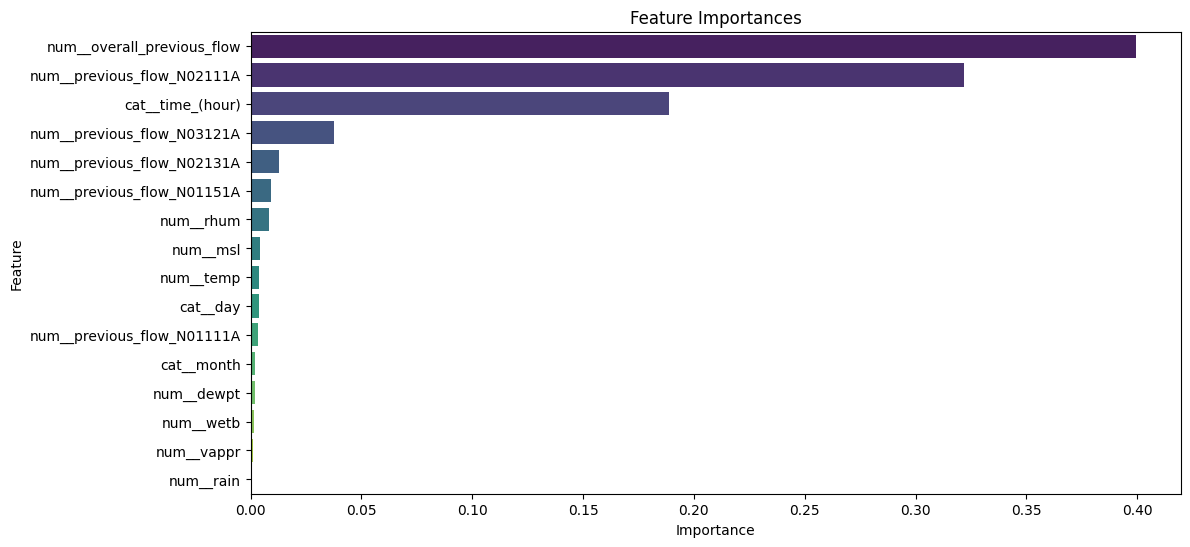

In [26]:
dt.transform_split_train_score_eval()

Observations
- The model performance doesn't seem to be getting any better using the decision tree model even though we are adding lots more information... why?
- Well we see the model performance is much better on the training set than the test set
    - This indicates <b>overfitting</b>
- You will find that adding more features to the model greatly increases the chances of overfitting
- Once you have gathered a significant amount of data for your problem, you will find the next phase is to create the best tradeoff between bias and variance via dimensionality reduction, feature selection, model selection and hyperparameter tuning. These are the topics we will explore next!


# In summary
- We were able to go from 2->21 features via feature engineering and integrating other data sources
- Although we added data we thought would be useful for increasing model accuracy, we saw model performance didn't seem to improve
- This highlights the prevalance of overfitting and just gathering your data and running it through a model isn't enough to improve model accuracy
